In [87]:
# !pip3 -q install cartopy
# !pip3 -q install verde

# !pip3 -q install contextily

In [88]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import verde as vd

import geopandas as gpd
import os
import numpy as np

import contextily as cx

In [89]:
fnames = {"invent_plots":"../shape_data/ROI_plots70/ROI_plots70.shp"}

gdf = gpd.read_file(fnames['invent_plots'])


/tmp/ipykernel_12/4097347213.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_84.loc[:, 'latitude'] = gdf_84['geometry'].centroid.y
/tmp/ipykernel_12/4097347213.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_84.loc[:, 'longitude'] = gdf_84['geometry'].centroid.x


Train and test size for random splits: 184 46
Train and test size for block splits:  183 47


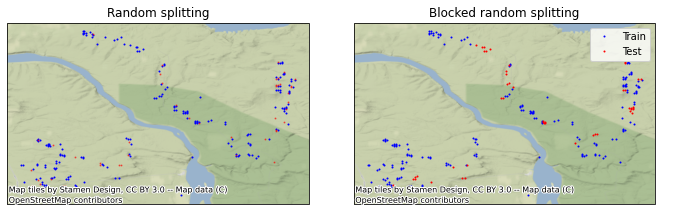

In [90]:

# Let's split the Baja California shipborne bathymetry data
# data = vd.datasets.fetch_baja_bathymetry()
gdf_84 = gdf.to_crs(epsg=4326)
gdf_84.loc[:, 'latitude'] = gdf_84['geometry'].centroid.y
gdf_84.loc[:, 'longitude'] = gdf_84['geometry'].centroid.x
data = gdf_84.copy()
coordinates = (data.longitude, data.latitude)
values = (np.array(data.index)) 

# Assign 20% of the data to the testing set.
test_size = 0.2

# Split the data randomly into training and testing. Set the random state
# (seed) so that we get the same result if running this code again.
train, test = vd.train_test_split(
    coordinates, values, test_size=test_size, random_state=123
)
# train and test are tuples = (coordinates, data, weights).
print("Train and test size for random splits:", train[0][0].size, test[0][0].size)

# A different strategy is to first assign the data to blocks and then split the
# blocks randomly. To do this, specify the size of the blocks using the
# 'spacing' argument.
train_block, test_block = vd.train_test_split(
    coordinates,
    values,
    spacing=0.015,
#     shape = [20,20],
    test_size=test_size,
    random_state=213,
)
# Verde will automatically attempt to balance the data between the splits so
# that the desired amount is assigned to the test set. It won't be exact since
# blocks contain different amounts of data points.
print(
    "Train and test size for block splits: ",
    train_block[0][0].size,
    test_block[0][0].size,
)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

# Make Mercator maps of the two different ways of splitting
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree())
)


ax1.set_title("Random splitting")
ax1.plot(*train[0], ".b", markersize=2, transform=crs, label="Train")
ax1.plot(*test[0], ".r", markersize=2, transform=crs, label="Test", alpha=0.5)
ax1.grid()
cx.add_basemap(ax1, crs=crs)
ax2.set_title("Blocked random splitting")
ax2.plot(*train_block[0], ".b", markersize=2, transform=crs, label="Train")
ax2.plot(*test_block[0], ".r", markersize=2, transform=crs, label="Test")
ax2.legend(loc="upper right")
ax2.grid()
cx.add_basemap(ax2, crs=crs)
plt.subplots_adjust(wspace=0.15, top=1, bottom=0, left=0.05, right=0.95)
plt.savefig('../plots/spatial_blocks_015_deg.png', dpi=300)
plt.show()


In [91]:
train_gdf = gdf.loc[train_block[-2]]
test_gdf = gdf.loc[test_block[-2]]

In [83]:
def get_train_test(gdf:gpd.GeoDataFrame, test_size: float, spacing:float = 0.015)->dict:
    gdf_84 = gdf.to_crs(epsg=4326)
    gdf_84.loc[:, 'latitude'] = gdf_84['geometry'].centroid.y
    gdf_84.loc[:, 'longitude'] = gdf_84['geometry'].centroid.x
    data = gdf_84.copy()
    coordinates = (data.longitude, data.latitude)
    values = (np.array(data.index)) 

    test_size = 0.2

    train, test = vd.train_test_split(
        coordinates, values, test_size=test_size, random_state=123
    )
    # train and test are tuples = (coordinates, data, weights).
    print("Train and test size for random splits:", train[0][0].size, test[0][0].size)

    train_block, test_block = vd.train_test_split(
        coordinates,
        values,
        spacing=spacing,
        test_size=test_size,
        random_state=213,
    )
    print(
        "Train and test size for block splits: ",
        train_block[0][0].size,
        test_block[0][0].size,
    )

    return {"train": gdf.loc[train_block[-2]],
           "test": gdf.loc[test_block[-2]]}

In [93]:
forest = gdf.loc[gdf['t_Class']<11]
dict_for_ml = get_train_test(forest, test_size=0.3, spacing=0.015)

Train and test size for random splits: 178 45
Train and test size for block splits:  179 44


/tmp/ipykernel_12/337439019.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_84.loc[:, 'latitude'] = gdf_84['geometry'].centroid.y
/tmp/ipykernel_12/337439019.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_84.loc[:, 'longitude'] = gdf_84['geometry'].centroid.x


In [104]:
train = dict_for_ml['train']
test = dict_for_ml['test']

In [106]:
!ls ..

LICENSE  README.md  metrics  notebooks	plots  run_in_docker.sh  shape_data


In [107]:
train.to_file('../shape_data/train_forest.geojson', driver='GeoJSON')
test.to_file('../shape_data/test_forest.geojson', driver='GeoJSON')

In [86]:
dict_for_ml['train']

,Plot_ID,t_С,t_Л,t_Б,t_ОС,t_Е,t_П,t_К,t_Клас,t_Class,geometry
0,14.0,0.813953,0.000000,0.116279,0.069767,0.000000,0.0,0.000000,С,7,"POLYGON ((656854.099 6275926.535, 656855.668 6..."
1,27.0,0.767857,0.035714,0.107143,0.089286,0.000000,0.0,0.000000,С,7,"POLYGON ((662190.184 6278821.988, 662191.753 6..."
2,29.0,0.020408,0.000000,0.173469,0.806122,0.000000,0.0,0.000000,ОС,5,"POLYGON ((657773.933 6280454.568, 657775.501 6..."
3,31.0,0.681818,0.022727,0.136364,0.000000,0.045455,0.0,0.113636,С,7,"POLYGON ((660102.838 6280175.395, 660104.406 6..."
4,34.0,0.000000,0.000000,0.885417,0.000000,0.114583,0.0,0.000000,Б,1,"POLYGON ((655012.854 6283465.079, 655014.422 6..."
...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,вода,11,"POLYGON ((670701.362 6284270.125, 671157.368 6..."
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,земля,12,"POLYGON ((671121.922 6273169.820, 671419.380 6..."
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,вырубка,13,"POLYGON ((672448.268 6292992.683, 672659.028 6..."
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,гарь,15,"POLYGON ((659745.714 6273736.714, 659895.162 6..."
